# Imports

In [1]:
!pip install -q PyWavelets fastai

In [2]:
import os
import random

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
        confusion_matrix, ConfusionMatrixDisplay,
        f1_score, multilabel_confusion_matrix, accuracy_score, classification_report)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import pywt
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
import torch.backends.cudnn as cudnn


def reproduce():
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
# reproduce()

In [4]:
print(torch.__version__)

2.0.0


# Preparing Data

In [5]:
!ls ../input/ptb-xl-100-hz
# !ls ../input/ptb-xl-lead-comparison

baseline_removed_100hz.npy


In [6]:
dataset_loc = "../input/ptb-xl-100-hz"

In [7]:
signals = np.load(os.path.join(dataset_loc, "baseline_removed_100hz.npy"))
signals.shape

(21388, 12, 1000)

In [8]:
faulty_index = 12498

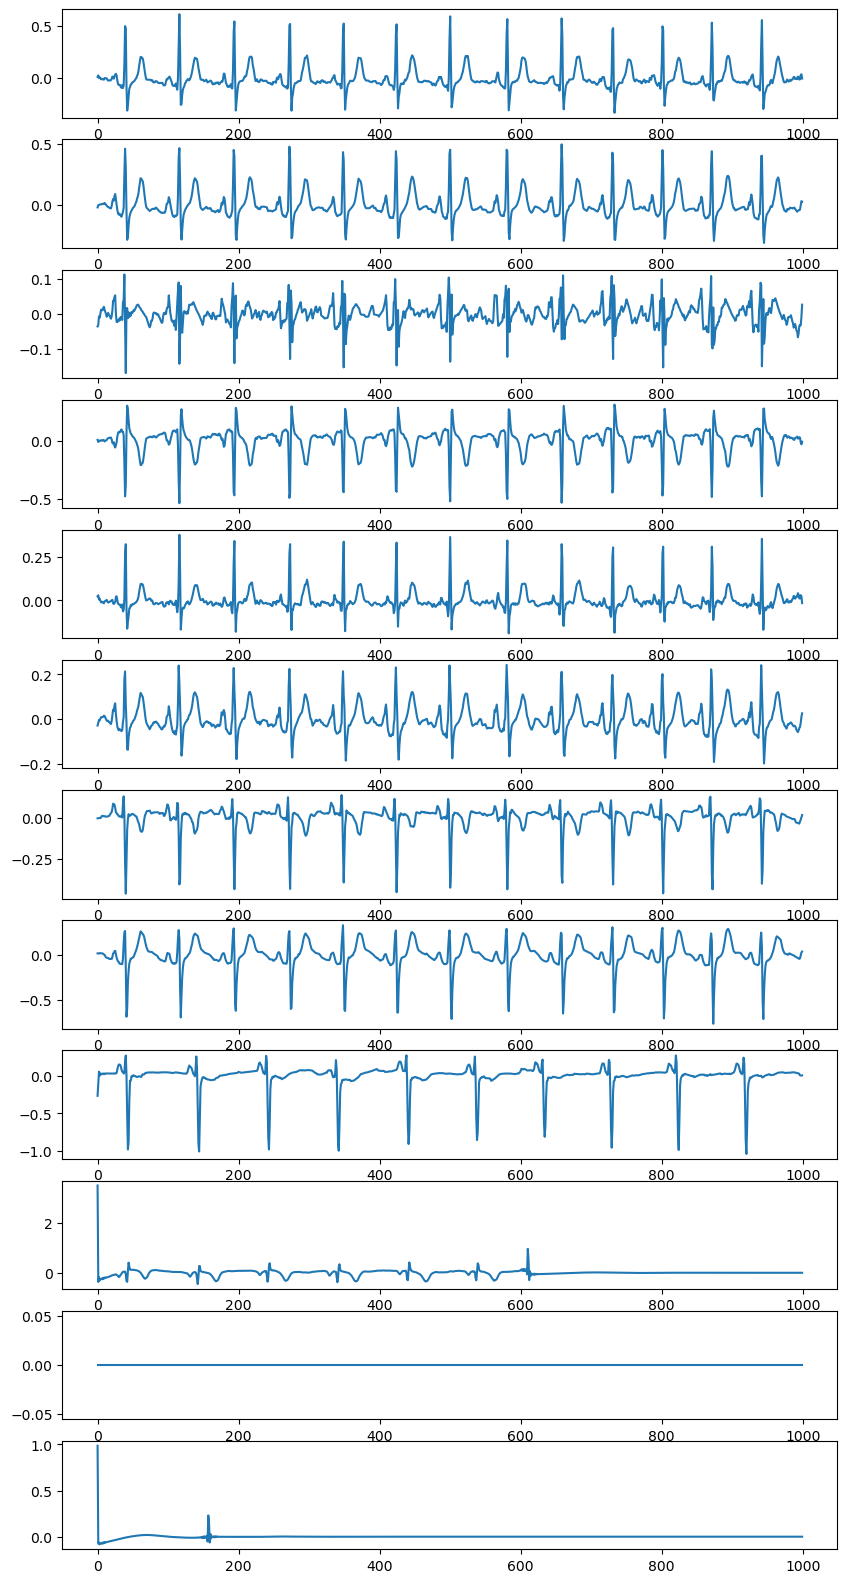

In [9]:
anomaly = signals[faulty_index]
fig, ax = plt.subplots(12, 1, figsize=(10, 20))
for i in range(12):
    ax[i].plot(anomaly[i])

In [10]:
signals = np.delete(signals, faulty_index, axis=0)
signals.shape

(21387, 12, 1000)

In [11]:
df = pd.read_csv("../input/ptb-xl-lead-comparison/labeled_df.csv")
df = df.drop(12498)
df = df.reset_index(drop=True)
df

,ecg_id,patient_id,age,sex,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,1,15709.0,56.0,1,3,records100/00000/00001_lr,records500/00000/00001_hr,1,0,0,0,0
1,2,13243.0,19.0,0,2,records100/00000/00002_lr,records500/00000/00002_hr,1,0,0,0,0
2,3,20372.0,37.0,1,5,records100/00000/00003_lr,records500/00000/00003_hr,1,0,0,0,0
3,4,17014.0,24.0,0,3,records100/00000/00004_lr,records500/00000/00004_hr,1,0,0,0,0
4,5,17448.0,19.0,1,4,records100/00000/00005_lr,records500/00000/00005_hr,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21382,21833,17180.0,67.0,1,7,records100/21000/21833_lr,records500/21000/21833_hr,0,0,1,0,0
21383,21834,20703.0,300.0,0,4,records100/21000/21834_lr,records500/21000/21834_hr,1,0,0,0,0
21384,21835,19311.0,59.0,1,2,records100/21000/21835_lr,records500/21000/21835_hr,0,0,1,0,0
21385,21836,8873.0,64.0,1,8,records100/21000/21836_lr,records500/21000/21836_hr,1,0,0,0,0


In [12]:
classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

In [13]:
classes2idx = {k:i for i, k in enumerate(classes)}
classes2idx

{'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}

In [14]:
test_df = df[df['strat_fold'] == 10]
val_df = df[df['strat_fold'] == 9]
train_df = df[df['strat_fold'] <= 8]

In [15]:
test_signals = signals[test_df.index]
val_signals = signals[val_df.index]
train_signals = signals[train_df.index]

In [16]:
print(test_signals.shape)
print(val_signals.shape)
print(train_signals.shape)

(2158, 12, 1000)
(2146, 12, 1000)
(17083, 12, 1000)


In [17]:
# from the metadata of WFDB sample
leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

leads_index = {l:i for i, l in enumerate(leads)}
leads_index

{'I': 0,
 'II': 1,
 'III': 2,
 'AVR': 3,
 'AVL': 4,
 'AVF': 5,
 'V1': 6,
 'V2': 7,
 'V3': 8,
 'V4': 9,
 'V5': 10,
 'V6': 11}

# PyTorch Dataset Class

In [18]:
def decompose(signal, level=3, **kwargs):
    lvl = kwargs.get("level", level)
    return pywt.wavedec(signal, 'db6', level=lvl)[0]

def minmax_norm(sig, **kwargs):
    s_min, s_max = sig.min(), sig.max()
    s_norm = (sig - s_min) / (s_max - s_min)
    return s_norm

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [20]:
# device = "cpu" # for debugging

# Pretraining

In [21]:
class NextValuePredictionDataset(Dataset):
    def __init__(self, df, signals, lead, ctx_length, pred_length, transform=None, **kwargs):
        self.df = df
        self.signals = signals
    
        self.lead = lead
        self.ctx_length = ctx_length
        self.pred_length = pred_length
        self.total_length = ctx_length + pred_length
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
#         instance = self.df.iloc[idx] # data instance
        signal = self.signals[idx]
        
        if type(self.lead) == list:
            channels = []
            for i in self.lead:
                channels.append(leads_index[i])
            signal = signal[channels]
        else:
            channel = leads_index.get(self.lead, None)
            if channel is not None:
                signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, **self.kwargs)
        
        max_index = signal.shape[-1] - self.total_length
        subset = signal[:, np.random.randint(0, max_index):]
        ctx = subset[:, :self.ctx_length]
        to_predict = subset[:,self.ctx_length:self.total_length]
        return torch.tensor(ctx).float(), torch.tensor(to_predict).float()

In [23]:
ctx_length = 700
pred_length = 100
dataset = NextValuePredictionDataset(train_df, train_signals, lead="all", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
dataset

In [24]:
ctx, pred = dataset[0]
ctx.shape, pred.shape

(torch.Size([12, 700]), torch.Size([12, 100]))

# Defining the architecture

In [25]:
class ECGResNet(nn.Module):
    def __init__(self, ctx_length, pred_length, num_channels, num_filters=64):
        super().__init__()
        self.ctx_length, self.pred_length, self.num_channels = ctx_length, pred_length, num_channels
        n_filters = num_filters
        self.conv_1 = nn.Conv1d(num_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(num_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
        
        self.fc_1 = nn.Linear(n_filters*2 * ctx_length, 512)
        self.fc_2 = nn.Linear(512, pred_length*num_channels)
#         self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
        
        # .view(x.size(0), -1)
        logits = self.fc_1(output_3.view(output_3.size(0), -1)) # flatten before passing
        logits = self.fc_2(logits)
#         print(output_3.mean((2,)).shape)
#         logits = self.classifier(output_3.mean((2,)))
#         res = logits
        return logits.view(-1, self.num_channels, self.pred_length)

In [26]:
base_model = ECGResNet(ctx_length,pred_length, num_channels=12)

# x = torch.randn(1, 12, 900)
# x.shape

# model(x).shape

# Pretraining once

In [27]:
BATCH_SIZE = 32

In [28]:
train_dataset = NextValuePredictionDataset(train_df, train_signals, lead="all", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
val_dataset = NextValuePredictionDataset(val_df, val_signals, lead="all", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)
test_dataset = NextValuePredictionDataset(test_df, test_signals, lead="all", ctx_length=ctx_length, pred_length=pred_length, transform=minmax_norm)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
for X, y in test_dataloader:
    test_shape = X.shape
    print(test_shape)
    break


torch.Size([32, 12, 700])


In [30]:
base_model = ECGResNet(ctx_length, pred_length, num_channels=test_shape[1]).to(device) 
dls = DataLoaders(train_dataloader, val_dataloader)
loss_fn = nn.L1Loss()
learner = Learner(
    dls,
    base_model,
    loss_func=loss_fn,    
    metrics=[mse, mae], # from fast ai
)

In [31]:
learner.fit(
    30, 
    lr=1e-3, 
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', comp=np.less, min_delta=0.0001,patience=3, reset_on_fit=True)
    ]
)

epoch,train_loss,valid_loss,mse,mae,time
0,0.061450,0.055967,0.008560,0.055967,00:25
1,0.046387,0.052065,0.008440,0.052065,00:19
2,0.038203,0.031316,0.003778,0.031316,00:19
3,0.036743,0.031309,0.003823,0.031309,00:19
4,0.033341,0.029468,0.003675,0.029468,00:19
5,0.033017,0.030443,0.003691,0.030443,00:19
6,0.031305,0.028804,0.003539,0.028804,00:19
7,0.031301,0.030038,0.003699,0.030038,00:19
8,0.032799,0.029083,0.003615,0.029083,00:19
9,0.031979,0.029691,0.003626,0.029691,00:19


No improvement since epoch 6: early stopping


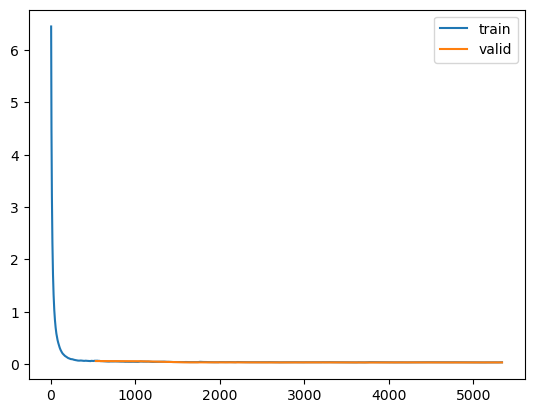

In [32]:
learner.recorder.plot_loss()

In [33]:
learner.model.eval()

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, prediction in tqdm(test_dataloader):
        output = learner.model(inputs.to(device).float())
        y_pred.extend(output)
        y_true.extend(prediction)
y_true = torch.stack(y_true).cpu()
y_pred = torch.stack(y_pred).cpu()

  0%|          | 0/68 [00:00<?, ?it/s]

In [34]:
mse_metric = mse(y_true, y_pred)
mae_metric = mae(y_true, y_pred)

print(f"MSE: {mse_metric}, MAE: {mae_metric}")

MSE: TensorBase(0.0036), MAE: TensorBase(0.0297)


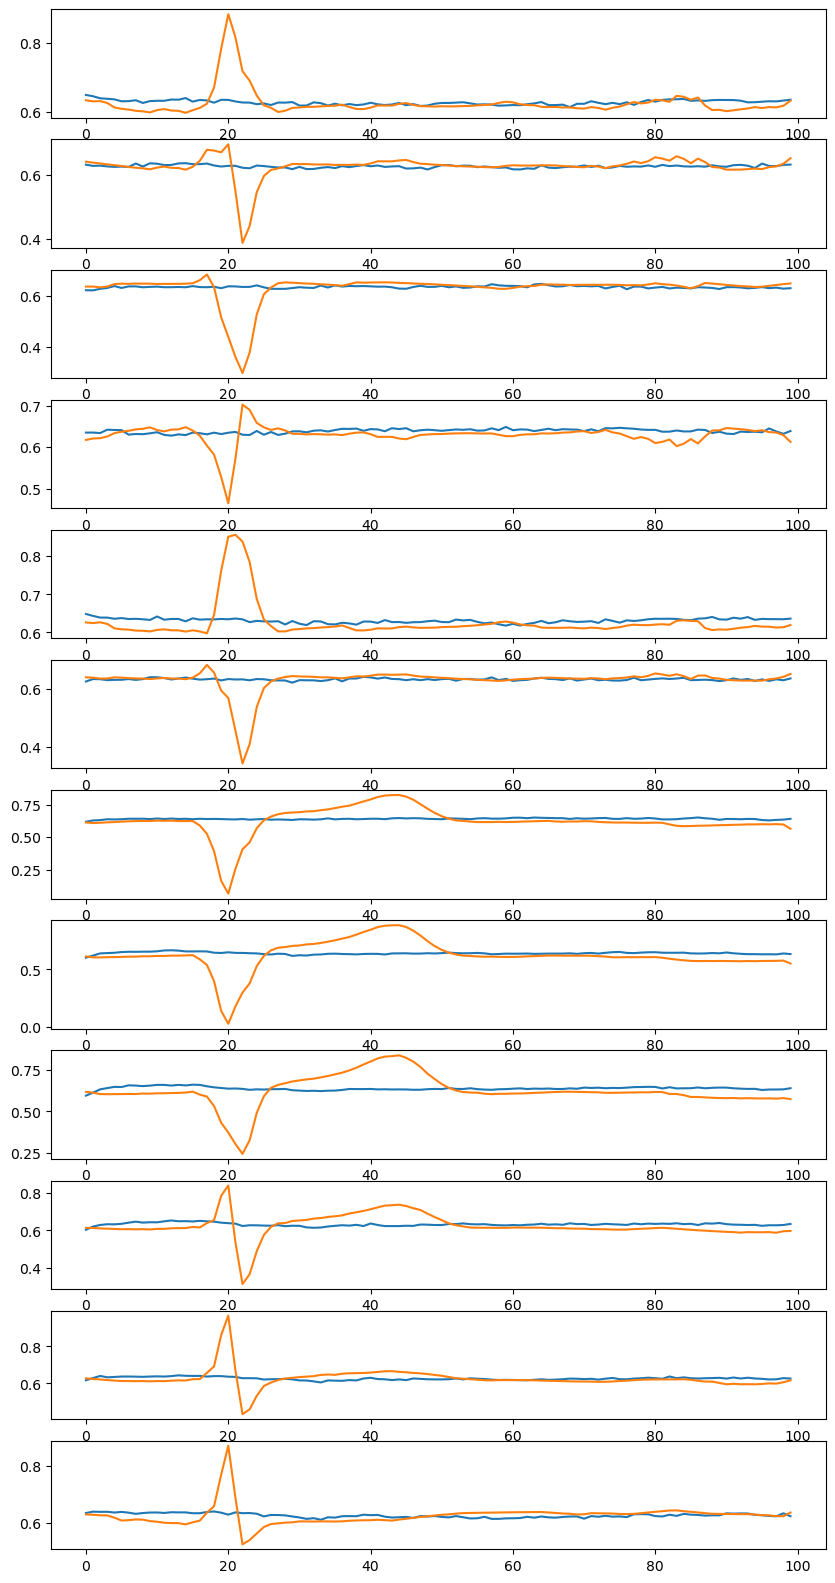

In [35]:
index = np.random.randint(y_true.shape[0])
fig, ax = plt.subplots(test_shape[1], 1, figsize=(10, 20))
for i in range(test_shape[1]):
    ax[i].plot(y_pred[index][i])
    ax[i].plot(y_true[index][i])

It's skipping the beats but the values are pretty close

# Fine-tuning for the disease detection

In [36]:
class DiseaseDetectionDataset(Dataset):
    def __init__(self, df, signals, lead, transform=None, **kwargs):
        self.df = df
        self.signals = signals
        self.lead = lead
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        instance = self.df.iloc[idx] # data instance
        label = train_df[classes].values[idx] #instance[self.k]
        signal = self.signals[idx]
        
        if type(self.lead) == list:
            channels = []
            for i in self.lead:
                channels.append(leads_index[i])
            signal = signal[channels]
        else:
            channel = leads_index.get(self.lead, None)
            if channel is not None:
                signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, **self.kwargs)
        
        return torch.tensor(signal).float().to(device), torch.tensor(label, dtype=torch.float32).to(device)

In [37]:
train_dataset_dd = DiseaseDetectionDataset(train_df, train_signals, "all", minmax_norm)
val_dataset_dd = DiseaseDetectionDataset(val_df, train_signals, "all", minmax_norm)
test_dataset_dd = DiseaseDetectionDataset(test_df, train_signals, "all", minmax_norm)

train_dataloader_dd = DataLoader(train_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_dd = DataLoader(val_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_dd = DataLoader(test_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
for x, y in test_dataloader_dd:
    test_shape = x.shape
    print(test_shape)
    break

torch.Size([32, 12, 1000])


In [39]:
class ECGResNetVanilla(nn.Module):
    def __init__(self, num_classes, num_channels, num_filters=64):
        super().__init__()
        n_filters = num_filters
        self.conv_1 = nn.Conv1d(num_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(num_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
        self.classifier = nn.Linear(n_filters*2, num_classes)
#         self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
        
        logits = self.classifier(output_3.mean((2,)))
#         res = self.sigmoid(logits)
#         return res.squeeze()
        return logits.squeeze()

In [53]:
dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
base_dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
# dd_model(torch.randn(test_shape).to(device)).shape

In [54]:
def copy_weights(model_1, model_2):
    first_model_layers = set([c[0] for c in model_1.named_children()])
    second_model_layers = set([c[0] for c in model_2.named_children()])

    common_layers = list(first_model_layers.intersection(second_model_layers))

    with torch.no_grad():
        for layer in common_layers:
            model_1.get_submodule(layer).weight.copy_(model_2.get_submodule(layer).weight)
            model_1.get_submodule(layer).bias.copy_(model_2.get_submodule(layer).bias)

In [55]:
copy_weights(dd_model, base_model)

# Model with pretrained weights

In [56]:
# dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
dls = DataLoaders(train_dataloader_dd, val_dataloader_dd)
loss_fn = nn.BCEWithLogitsLoss()
learner = Learner(
    dls,
    dd_model,
    loss_func=loss_fn,    
    metrics=[F1ScoreMulti(sigmoid=True)] # from fast ai
)

In [58]:
learner.fit(
    70, 
    1e-3,
#     cbs=[
#         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True)
#     ]
)

epoch,train_loss,valid_loss,f1_score,time
0,0.380605,0.352933,0.434218,00:35
1,0.352888,0.335172,0.518848,00:35
2,0.314531,0.939305,0.352787,00:35
3,0.314204,0.486796,0.483241,00:35
4,0.308812,0.313973,0.613685,00:35
5,0.307027,0.311605,0.608959,00:35
6,0.306200,0.310959,0.574047,00:35
7,0.296886,0.360420,0.573532,00:35
8,0.282700,0.378759,0.570362,00:35
9,0.284503,0.330007,0.566394,00:35


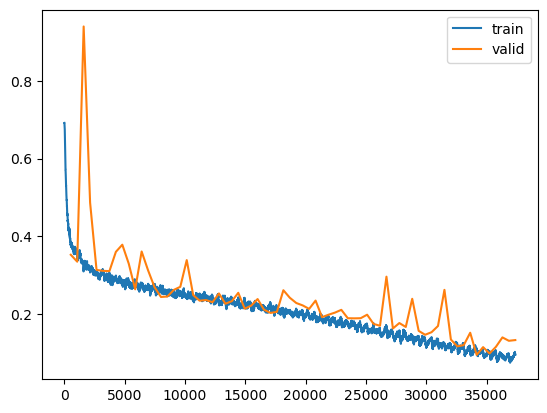

In [59]:
learner.recorder.plot_loss()

In [60]:
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader_dd):
        output = dd_model(inputs.to(device).float())
#         output = (output > 0.5).int()
        y_pred.extend(output)
#         labels = labels.data.cpu().int().numpy()
        y_true.extend(labels)
y_true = torch.stack(y_true).cpu()
y_pred = torch.stack(y_pred).cpu()

  0%|          | 0/68 [00:00<?, ?it/s]

In [61]:
preds = (torch.sigmoid(y_pred) > 0.5).int()
f1_score = F1ScoreMulti()
f1_score(y_true, preds)

0.875730337306978

# Baseline model for comparison

In [62]:
# dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
dls = DataLoaders(train_dataloader_dd, val_dataloader_dd)
loss_fn = nn.BCEWithLogitsLoss()
learner = Learner(
    dls,
    base_dd_model,
    loss_func=loss_fn,    
    metrics=[F1ScoreMulti(sigmoid=True)] # from fast ai
)

In [63]:
learner.fit(
    70, 
    1e-3,
#     cbs=[
#         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True)
#     ]
)

epoch,train_loss,valid_loss,f1_score,time
0,0.347981,0.367551,0.561857,00:35
1,0.317593,0.308028,0.595593,00:35
2,0.294114,0.310040,0.572631,00:35
3,0.302715,0.308434,0.601000,00:35
4,0.285059,0.360823,0.575024,00:35
5,0.280426,0.290728,0.641168,00:35
6,0.281253,0.304321,0.627983,00:35
7,0.263454,0.249519,0.673436,00:35
8,0.264102,0.261127,0.650248,00:35
9,0.254894,0.258114,0.667650,00:35


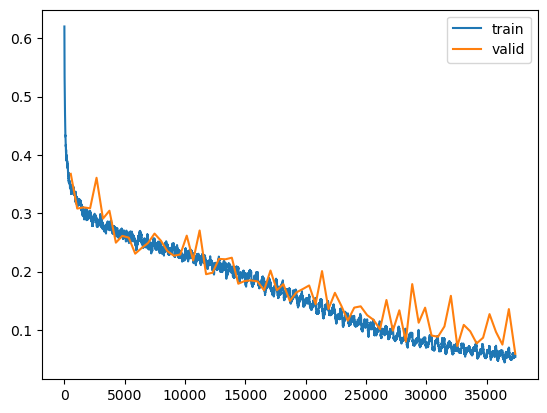

In [64]:
learner.recorder.plot_loss()

In [65]:
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader_dd):
        output = base_dd_model(inputs.to(device).float())
#         output = (output > 0.5).int()
        y_pred.extend(output)
#         labels = labels.data.cpu().int().numpy()
        y_true.extend(labels)
y_true = torch.stack(y_true).cpu()
y_pred = torch.stack(y_pred).cpu()

  0%|          | 0/68 [00:00<?, ?it/s]

In [66]:
preds = (torch.sigmoid(y_pred) > 0.5).int()
f1_score = F1ScoreMulti()
f1_score(y_true, preds)

0.9405380916306992